In [1]:
from RLTrain import Opt
import os
import time
#print(Opt())
import pandas as pd

from matplotlib.scale import FuncScale
from RadarGraph import *
#plt.rcParams["font.size"]=14.0
import sys
sys.path.append('../')

from visualization_helper import *

# Methods for Trajectory parsing and Visualization

In [2]:
def hashed_trajectories(frame,N=None,N2=None,gamma=1):
    """Turns rollouts into a dictionary of trajectories and counts by hashing episodes based on the actions taken.
    
    Args:
    - frame (dataframe):   Pandas Dataframe containing rollouts
    - N (int):             Number of actions in MultiDiscrete dim 0
    - N2 (int):            Number of actions in MultiDiscrete dim 1
    
    Returns:
    - trajectories (dict): String representations of actions are keys and values are of the form (count,mean_return)
    
    Example: 
    
    >>> print(frame) 
    >>>         InState  Action  Reward  OutState   Done Info  Step
            0  0.631918  [0, 9]     0.0  0.632225  False   {}     0
            1  0.632225  [0, 9]     0.0    0.6319  False   {}     1
            2    0.6319  [4, 4]     0.8    0.6319   True   {}     2
            
    >>> hashed_trajectories(frame)
    >>> {'090944': 1}
    
    """
    min_t,max_t = frame.Step.min(),frame.Step.max()
    mean_act=[]
    
    act = np.stack(frame.Action)  

    trajectories=dict()
    
    if N is None:
        N = np.max(act[:,0])
    act_string=""
    ret=0
    for t,act in enumerate(frame.Action):
        if frame.Step[t]==0:
            act_string=""
            ret=0
        if len(act.shape)<1:
            act0=int(act)
            act=np.zeros((2,),dtype=np.int32)
            act[0]=act0//N2
            act[1] = act0%N2
        act_string+=(str(act[0])+str(act[1]))
        ret += frame.Reward[t]*gamma**frame.Step[t]
        if frame.Done[t]:
            count,ret0 = trajectories.get(act_string,(0,0))
            trajectories[act_string] = (count+1,(ret+count*ret0)/(count+1))
            
            
    return trajectories



def relabel_trajectory(trajectory:dict,pouring_actions:set,wait_string:str,
                       end_string,bins_per_action:int,default_wait="1",dependencies=dict()):
    """
    Method to re-label a trajectory such that actions that don't do anything are replaced with waiting and
    the end experiment actions all have the same sub-action value
    """
    new_trajectory=""
    center=str(int(bins_per_action//2))
    i_dependencies={dependencies[a]:a for a in dependencies}
    satisfied= {a:0 for a in dependencies}
    
    for action,param in zip(trajectory[::2],trajectory[1::2]):
        
        if param!="0" and action in i_dependencies:
            satisfied[i_dependencies[action]]+=1
        if param=="0" and action in pouring_actions:
            #Pouring zero amount is the same as waiting
            action=wait_string
            param=default_wait
        elif action in dependencies and not satisfied[action]:
            action=wait_string
            param=default_wait
        #standardize the end experiment action
        if action == end_string:
            param=center
            
        new_trajectory+=action+param
                
    return new_trajectory

def relabel_trajectories(trajectories:dict,pouring_actions:set,wait_string:str,
                         end_string,bins_per_action:int,default_wait="1",dependencies=dict(),use_return=False):
    """
    Recompute a trajectory dictionary using relabel_trajectory
    """
    new_traj=dict()
    #make function calls easier
    relabel=lambda x: relabel_trajectory(x,pouring_actions,wait_string,end_string,bins_per_action,default_wait,dependencies)
    
    for key in trajectories:
        key2 = relabel(key)
        #get new count and average return
        count0,ret0 = trajectories[key]
        count,ret = new_traj.get(key2,(0,0))
        new_traj[key2] = (count0+count,(ret*count+count0*ret0)/(count0+count))
            
    return new_traj

In [3]:
def get_stat_key(traj,stat="median",tol=1e-6):
    sorted_hashes = sorted([a for a in traj],key=lambda x:traj[x][1],reverse=True)
    sorted_amounts = np.array([traj[x][0] for x in sorted_hashes])
    median_count=sorted_amounts.sum()/2
    total_count=0
    
    if stat=="min":
        stat_key = sorted_hashes[-1]
    elif stat=="max":
        stat_key = sorted_hashes[0]
    else:
      for i,count in enumerate(sorted_amounts):
        total_count+=count
        if total_count>=median_count:
            stat_key = sorted_hashes[i]
    
    return stat_key
    stat_return=traj[stat_key][1]
    for key in traj:
        count,ret=traj[key]
        #if abs(ret-stat_return)<tol:print(ret,,count)
        if abs(ret-stat_return)<tol and (count>traj[stat_key][0] or (count==traj[stat_key][0] and len(key)<len(stat_key))):
            stat_key=key
    return stat_key

In [4]:
def show_trajectories(trajectories:dict, actions, bins_per_action, figsize=(7,3),
                      alpha_map=lambda x:x**2, max_allowed=1e6, fig_ax=None, L=None,use_return=False, **kwargs):

    """
    Plots a dictionary of hashed trajectories with transparency based off of the alpha map
    
    Args:
    - trajectories (dict): Dictionary where keys are the trajectories and values are weights 
            (ex: keys are number trajectory counts, or reward achieved with the trajectory)
    - actions (list of str): List of the names of each action
    - bins_per_action (int): The number of bins for each main action in the multidiscrete
    - figsize (tuple): The size you want the figure to be
    - alpha_map (function): A function that translates normalized values (divided by the max to fit in (-inf,1))
            to alpha values
    - max_allowed (float): The maximum number of trajectories which can be plotted
    
    """

    b = bins_per_action
    tograph = lambda x: [int(i)*10+float(x[2*j+1])*7.8/b+(9-9*.78)/2 for j,i in enumerate(x[::2])]
    
    #order the dict based on frequency
    sorted_hashes = sorted([a for a in trajectories],key=lambda x:trajectories[x][use_return],reverse=True)
    sorted_amounts = [trajectories[x][use_return] for x in sorted_hashes]
    
    #scale the graph
    if L is None:
        L=max(12,len(sorted_hashes[0])//2)
    
    if fig_ax is None:
        fig = plt.figure(1,figsize=figsize, dpi=240, facecolor='w', edgecolor='k')
        ax=plt.gca()

        for j,act in enumerate(actions[::-1]):
            j=len(actions)-j-1
            plt.fill_between([-0.5,L],[j*10-0.5,j*10-0.5],[j*10+9.5,j*10+9.5],alpha=0.5)
            plt.text(L*0.9875,j*10+5,act,horizontalalignment="right",bbox=dict(boxstyle="square",facecolor="w",edgecolor="k",alpha=0.2))

        plt.xlabel("Step")
        plt.ylabel("Action")
        plt.xlim(-0.5,L)
        plt.ylim(-0.5,len(actions)*10-0.5)
        plt.yticks([])
    
    
    else:
        fig,ax=fig_ax
    for a,string in enumerate(sorted_hashes):
        if a<max_allowed:
            plt.plot(tograph(string),".-",alpha=alpha_map(sorted_amounts[a]/sorted_amounts[0]),**kwargs)
        else:break
            

    return fig,ax

In [5]:
def make_heatmap(frame,N=None,N2=None,use_return=False):
    """Turns rollouts into an array which counts the number of times an action was taken at a certain step
    
    Args:
    - frame (dataframe):   Pandas Dataframe containing rollouts
    - N (int):             Number of actions in MultiDiscrete dim 0
    - N2 (int):            Number of actions in MultiDiscrete dim 1
    
    Returns:
    - heatmap (np.array): the heatmap
    """
    
    min_t,max_t = frame.Step.min(),frame.Step.max()
    
    act = np.stack(frame.Action)  

    
    
    if N is None:
        N = np.max(act[:,0])
    
    heatmap=np.zeros([max_t+1,(N+1)*N2])
        
    for t,act in enumerate(frame.Action):
        if len(act.shape)<1:
            act0=int(act)
            act=np.zeros((2,),dtype=np.int32)
            act[0]=act0//N2
            act[1] = act0%N2
        heatmap[frame.Step[t],act[0]*N2+act[1]]+=1
    return heatmap

# Distillation Bench

In [9]:
parent_dir = "MODELS\\GenWurtzDistill-v1"
folders = load_rollouts(parent_dir,obj=max_obj,last=False,verbose=False)

#if "Heuristic" in folders:
#    dheuristic=folders["Heuristic"]
#    del folders["Heuristic"]
#else:
#    dheuristic = pd.read_pickle("MODELS\\WurtzDistill-v1\\Heuristic\\rollout")

## Results During Training

In [ ]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]



for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=200,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=1,steps=200)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv,mean+stdv,color=colors[i],alpha=0.4,lw=0)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")

plt.plot([steps[0],np.ceil(steps[-1]/1e3)*1e3],[0.82,0.82],"k--",label="Best Possible Return")

plt.plot([0,1e5],[0.0,0.0],"k-")

plt.legend(loc="lower right")  

#plt.yscale(FuncScale(plt.gca(),(lambda x: x*(x>0)+x*(x<=0)/20,lambda x: x*(x>0)+x*(x<=0)*20)))
#plt.yticks([-60,-40,-20,0,1])

plt.ylim(-5,1)



plt.title("WurtzDistill-v1 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

# Looking at trajectories

In [ ]:
CWtargs

In [ ]:
def salt_check(frame,get_salt=True,has_salt_targ=False):
    is_salty = np.array([a["NaCl"] for a in frame.Info])
    if get_salt:
        cframe=frame[is_salty]
    else:
        cframe=frame[~is_salty]
        
    if not has_salt_targ:
        obs = np.stack(cframe.InState)
        cframe=cframe[obs[:,0,-1]<0.9]
        
    cframe=pd.concat([cframe],ignore_index=True)
    return cframe


#salt_check(folders["DQN"],False)

In [ ]:
actions = ['dT', 'Pour 0->1', 'Pour 1->2', 'Wait', 'End Experiment' ]

cframe=salt_check(folders["PPO"],True)
print(cframe.shape)

raw_trajectories=hashed_trajectories(cframe,N=4,N2=10)


quantized_trajectories=raw_trajectories

sizes=np.array([quantized_trajectories[a] for a in quantized_trajectories])

ratio=sizes.max()/np.sum(sizes)*2

show_trajectories(quantized_trajectories,actions,10,alpha_map=lambda x:x*ratio,color="k")
plt.title("PPO Most Common Trajectories (Distillation Bench: All 10 runs, Best Checkpoint)")
#plt.yticks([1,4.5,8,11,18,21,28,31,38],[-1,0,1,0,1,0,1,0,1])
plt.show()

In [ ]:
colors={"PPO":"darkgreen","PPO-XL":"darkred","A2C":"darkgoldenrod","DQN":"darkblue"}
markers={"PPO":".","PPO-XL":"*","A2C":"^","DQN":"2"}

figax=None
legend=[]
for alg in ["DQN","A2C","PPO","PPO-XL"]:

    cframe=salt_check(folders[alg],True)
    
    raw_trajectories=hashed_trajectories(cframe,N=4,N2=10,gamma=1.0)
    #quantized_trajectories=raw_trajectories
    
    info_key=get_stat_key(raw_trajectories,"max")
    print(info_key)
    info_dict={info_key:raw_trajectories[info_key]}
    label=alg+" (%.2f)"%raw_trajectories[info_key][1]
    
    figax=show_trajectories(info_dict, actions, 10, figsize=(16,4), max_allowed=1, fig_ax=figax,L=24,ms=8,color=colors[alg],marker=markers[alg],label=label)

figax[1].legend(loc=(0.5,0.7),fontsize=8)

plt.savefig("Legacy\\Figures\\Extraction\\All_Trajectories.pdf")

plt.title("Best Trajectory")

#plt.yticks([1,4.5,8,11,18,21,28,31,38],[-1,0,1,0,1,0,1,0,1])
plt.show()

In [ ]:

for alg in ["DQN","A2C","PPO","PPO-XL"]:
    
    quantized_trajectories = hashed_trajectories(folders[alg],N=4,N2=10)    
    sizes=np.array(sorted([quantized_trajectories[a][0] for a in quantized_trajectories]))
    ratio=sizes.max()/np.sum(sizes[-100:])*4
    print(sizes.max())
    map_=lambda x:np.clip(x*ratio,0,1)
    show_trajectories(quantized_trajectories,actions,10,figsize=(8,4),alpha_map=map_,L=15,color=colors[alg],marker=markers[alg],
                     max_allowed=1e2)
    plt.savefig(f"Legacy\\Figures\\Extraction\\Traj{alg}.pdf",bbox_inches="tight")
    plt.show()

# Extraction Bench

In [12]:
parent_dir = "MODELS\\GenWurtzExtract-v2"
#parent_dir="MODELS\\DiscreteWurtzExtract-v1\\PPO-XL\\13-03-2023--06-08-15"
folders = load_rollouts(parent_dir,obj=None,last=False,verbose=False)


#eheuristic = pd.read_pickle("MODELS\\WurtzExtract-v1\\Heuristic\\rollout")
    
    
    
ACTIONS_V2=["Drain EV to B1", "Mix EV","Pour B2 into EV","Pour B1 into EV", 
        "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","Wait","End Experiment"]


ACTIONS_V1=["Drain EV to B1", "Mix EV","Pour B1 into EV","Pour B2 into EV", 
            "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","End Experiment","Wait (Implicit)"]

In [ ]:
del folders["PPO-XL"]

## Results During Training

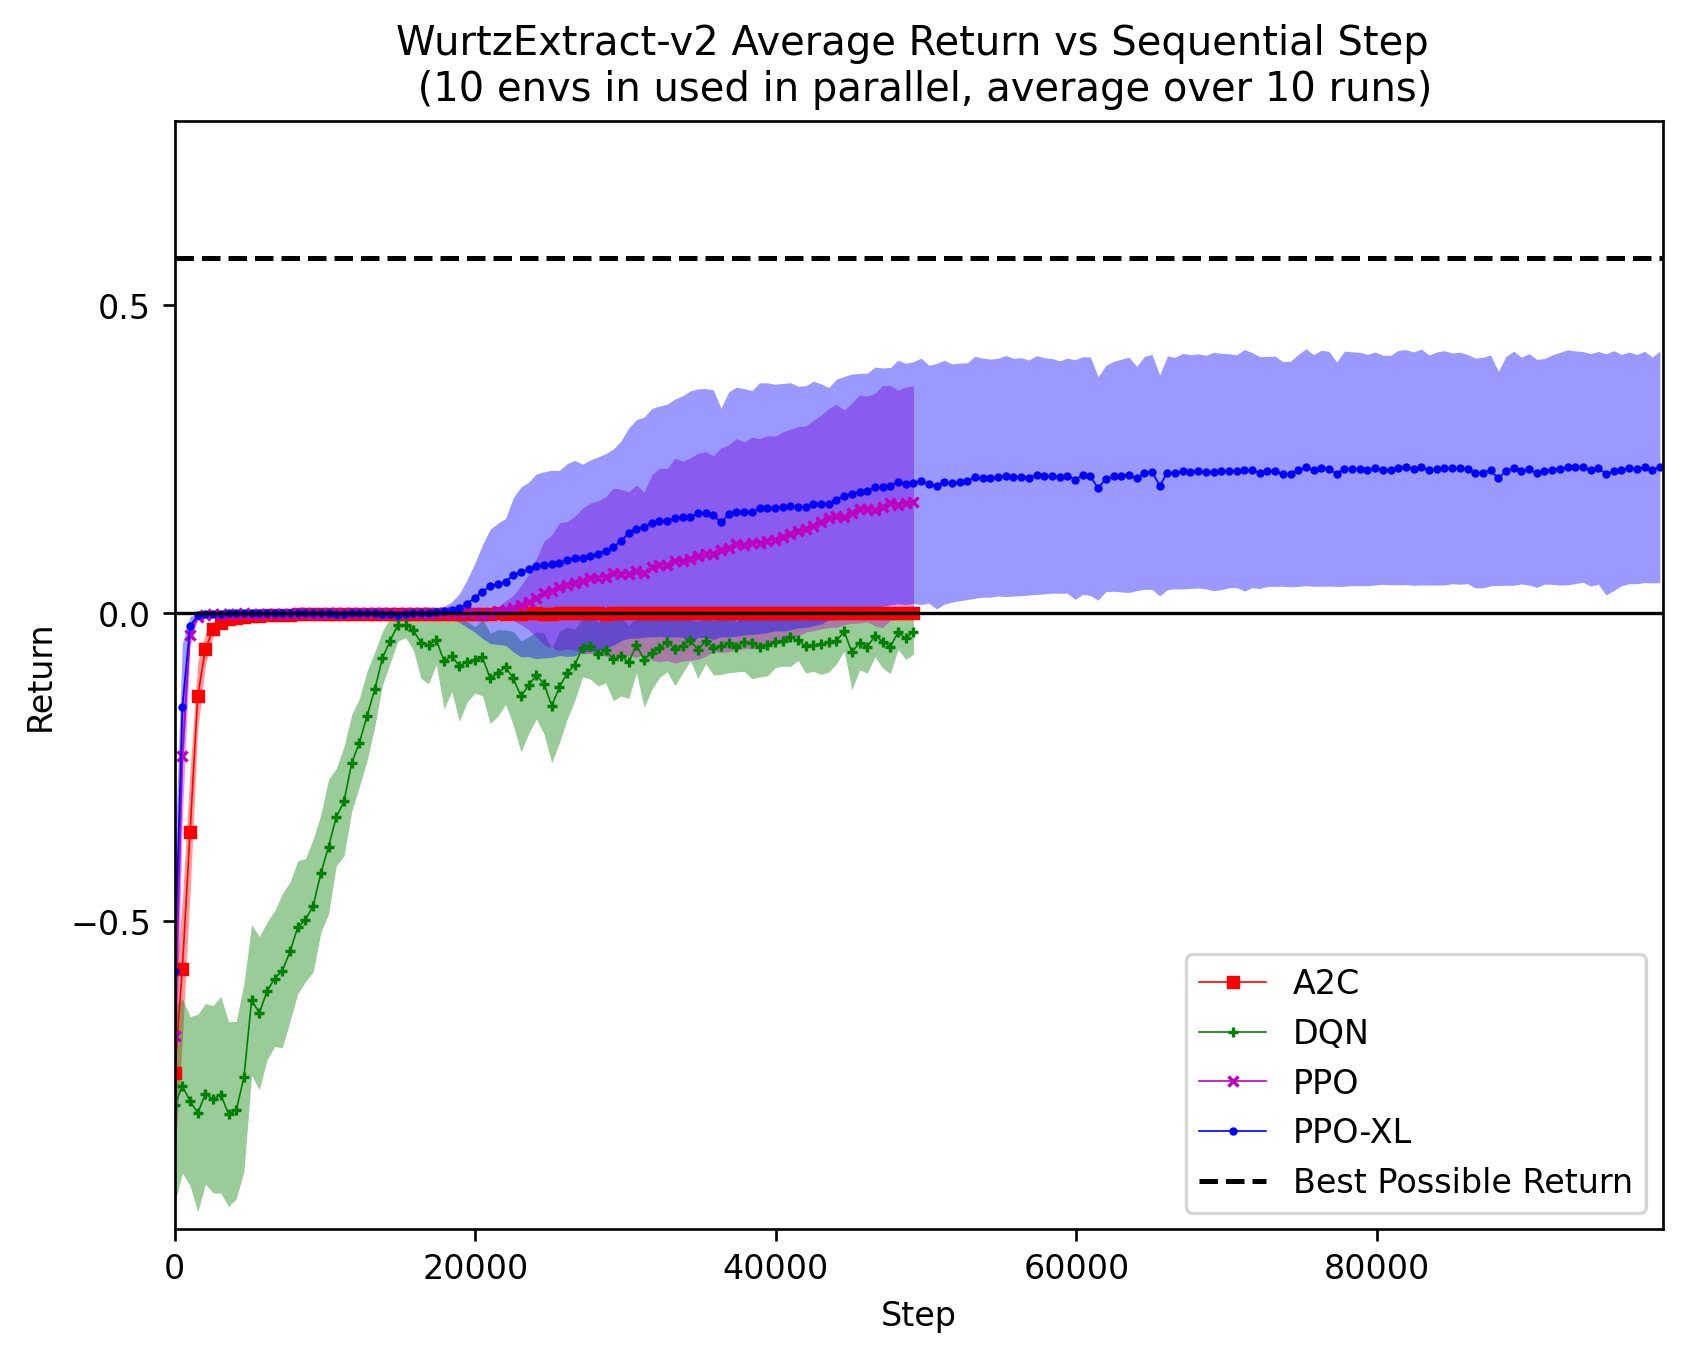

In [13]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=512,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=1,steps=512)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv,mean+stdv,color=colors[i],alpha=0.4,lw=0)
    
    
plt.plot([steps[0],np.ceil(steps[-1]/1e3)*1e3],[4/7+4/700,4/7+4/700],"k--",label="Best Possible Return")

plt.plot([0,1e5],[0.0,0.0],"k-",lw=1)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend(loc="lower right")
plt.ylim(-1,0.8)
#plt.yscale(FuncScale(plt.gca(),(lambda x: x*(x>0)+x*(x<=0)/10,lambda x: x*(x>0)+x*(x<=0)*10)))
plt.yticks([-0.5,0,0.5])
plt.savefig("Legacy\\Figures\\GenExtraction2\\Extract2runs.pdf",bbox_inches="tight")
plt.title("WurtzExtract-v2 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

# Looking at Trajectories

In [ ]:
frame = folders["PPO-XL"]
obs = np.stack(frame.InState)
obs=obs[:,0,:]
cond = (obs[:,-1]>0.9)

In [ ]:
frame[cond].shape

In [15]:
actions=ACTIONS_V2

7450747374747473742274747473747373737474037474730304030380
745020747474737473737474747403737403740403047380
2050747474737474747374730373037403040480
32507473717374737474717474037403740402041480
7050207474737371737474747474737322737374730374037404030380
315074747374747473747474737473747474740374037404030380
52302171247373737474733021747324737302240473030304641180


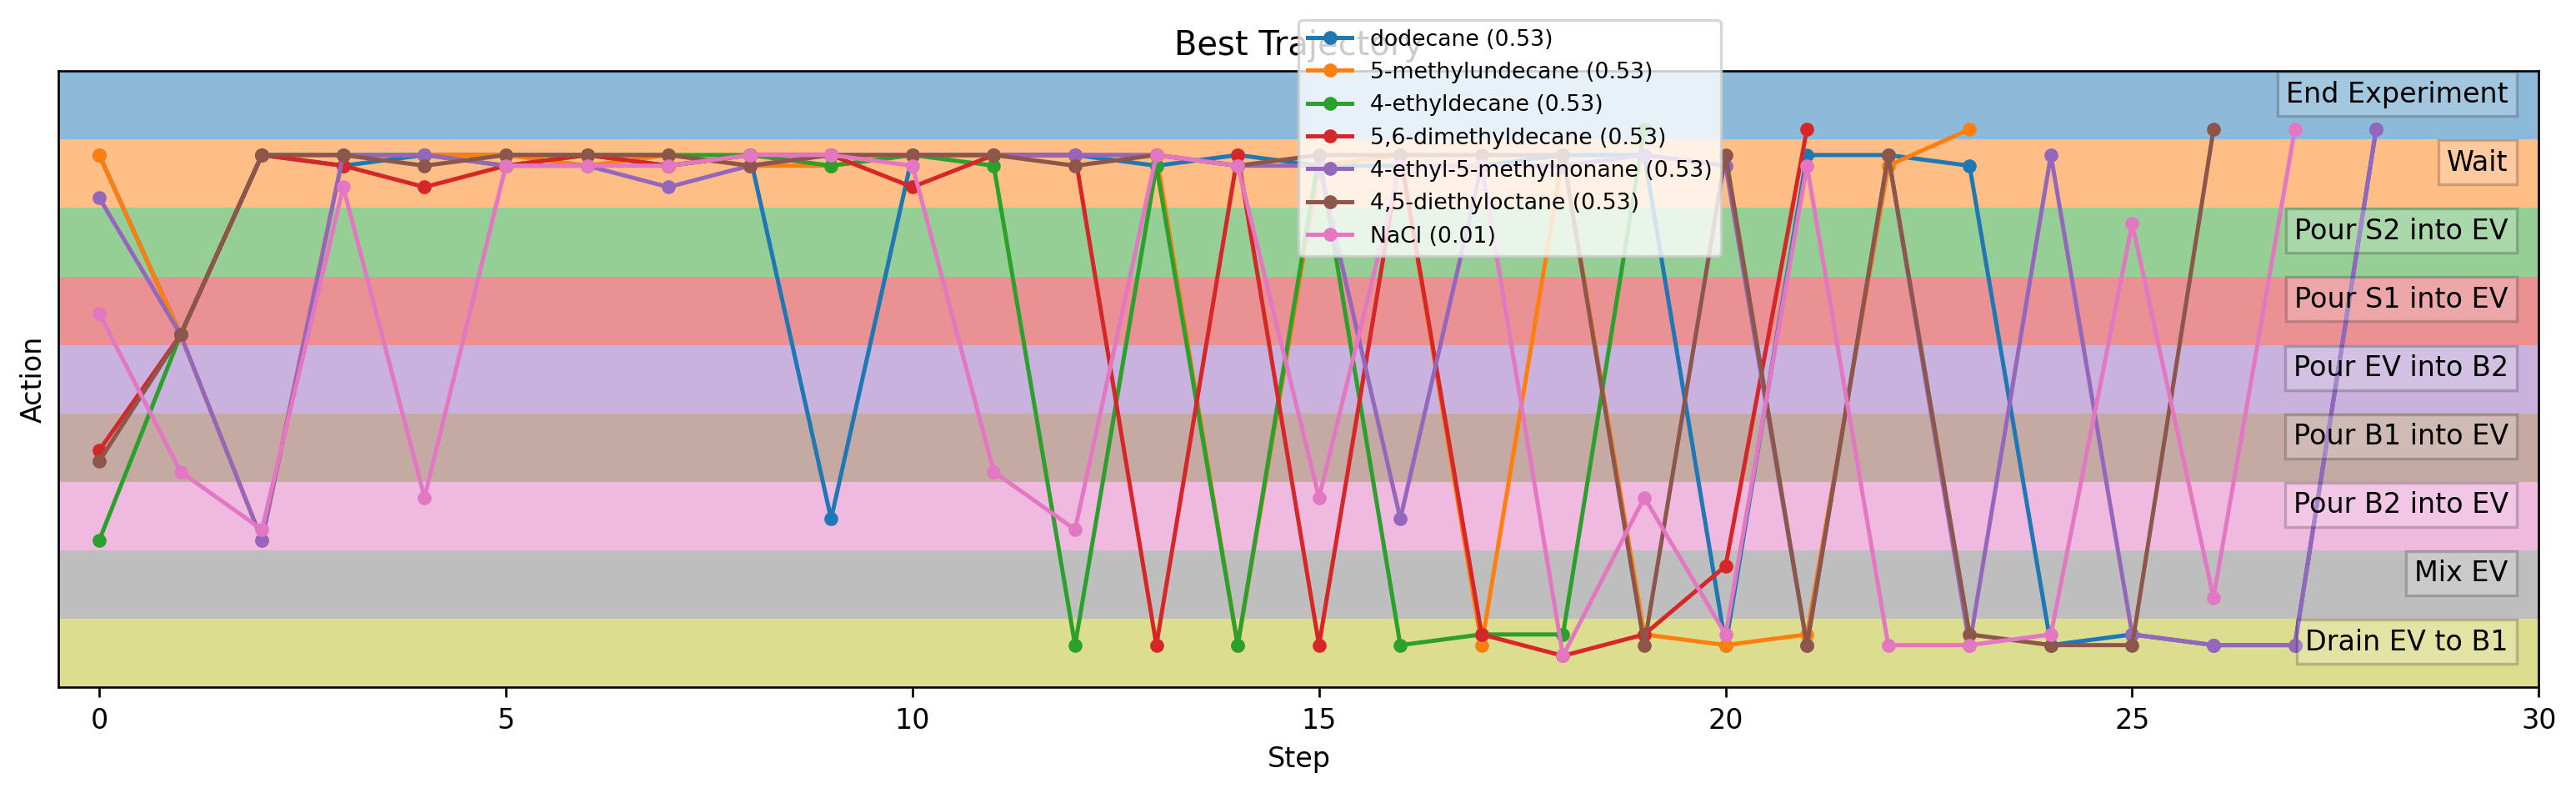

In [16]:
N=len(CWtargs)

figax=None  



for i,targ in enumerate(CWtargs):

    subset = target_subset(folders["PPO-XL"],N,i)
            
    raw_trajectories=hashed_trajectories(subset,N=7,N2=5)
    #quantized_trajectories=relabel_trajectories(raw_trajectories,{"0","1","2","3","4","5","6"},"8","7",5,default_wait="0",dependencies=dependencies,use_return=True)
    
    quantized_trajectories=raw_trajectories
    
    info_key=get_stat_key(raw_trajectories,"max")
    
    print(info_key)
        
    info_dict={info_key:quantized_trajectories[info_key]}
    
    label=targ+" (%.2f)"%quantized_trajectories[info_key][1]
    
    
    figax=show_trajectories(info_dict, actions, 5, figsize=(16,4), max_allowed=1,
                            fig_ax=figax, L=30, use_return=False, ms=8, label=label)

    
figax[1].legend(loc=(0.5,0.7),fontsize=8)

plt.savefig("Legacy\\Figures\\GenExtraction2\\All_Trajectories.pdf")

plt.title("Best Trajectory")

plt.show()

In [ ]:
actions=ACTIONS_V2

dependencies={"2":"0","3":"4"}
colors={"PPO":"darkgreen","PPO-XL":"darkred","A2C":"darkgoldenrod","DQN":"darkblue"}
markers={"PPO":".","PPO-XL":"*","A2C":"^","DQN":"2"}
figax=None

legend=[]

for alg in ["DQN","A2C","PPO","PPO-XL"]:


    
    raw_trajectories=hashed_trajectories(folders[alg],N=7,N2=5)
    #quantized_trajectories=relabel_trajectories(raw_trajectories,{"0","1","2","3","4","5","6"},"8","7",5,default_wait="0",dependencies=dependencies,use_return=True)
    
    quantized_trajectories=raw_trajectories
    info_key=get_stat_key(raw_trajectories,"max")
        
    info_dict={info_key:quantized_trajectories[info_key]}
    
    print(alg,info_dict)
    
    legend.append(f"{alg} (%.2f)"%quantized_trajectories[info_key][1])
    figax=show_trajectories(info_dict, actions, 5, figsize=(16,4), max_allowed=1, fig_ax=figax,L=30,ms=8,color=colors[alg],marker=markers[alg],label=legend[-1])

figax[1].legend(loc=(0.5,0.7),fontsize=8)

plt.savefig("Legacy\\Figures\\Extraction2\\All_Trajectories.pdf")

plt.title("Best Trajectory")

#plt.yticks([1,4.5,8,11,18,21,28,31,38],[-1,0,1,0,1,0,1,0,1])
plt.show()

In [ ]:
def angleToRGB(theta,sc,w):
    
    #squish the greens
    if theta<67.5:
        theta=theta*0.8
    elif theta<157.5:
        theta=theta*2-72
    else:
        theta=theta*0.8+72
    
    
    r=(theta/360+1.0/6)%1.0;
    b=(theta/360+3.0/6)%1.0;
    g=(theta/360+5.0/6)%1.0;
    #colorwheel assignment multiplied by the scaler sc
    r = (1 if r<1.0/3 else 3-6*r if r<1.0/2 else 0 if r<5.0/6 else 6*r-5)*sc+w;
    g = (1 if g<1.0/3 else 3-6*g if g<1.0/2 else 0 if g<5.0/6 else 6*g-5)*sc+w;
    b = (1 if b<1.0/3 else 3-6*b if b<1.0/2 else 0 if b<5.0/6 else 6*b-5)*sc+w;
    
    r=min(r,1)
    g=min(g,1)
    b=min(b,1)

    return [r,g,b]


In [ ]:
def show_trajectories3D(trajectories:dict,actions,bins_per_action,figsize=(7,3),alpha_map=lambda x:x**2,max_allowed=1e6):

    """
    Plots a dictionary of hashed trajectories with transparency based off of the alpha map
    
    Args:
    - trajectories (dict): Dictionary where keys are the trajectories and values are weights 
            (ex: keys are number trajectory counts, or reward achieved with the trajectory)
    - actions (list of str): List of the names of each action
    - bins_per_action (int): The number of bins for each main action in the multidiscrete
    - figsize (tuple): The size you want the figure to be
    - alpha_map (function): A function that translates normalized values (divided by the max to fit in (-inf,1))
            to alpha values
    - max_allowed (float): The maximum number of trajectories which can be plotted
    
    """

    b = bins_per_action
    #actions
    to_z = lambda x: [int(i) for j,i in enumerate(x[::2])]
    #sub-values
    to_y = lambda x: [int(x[2*j+1])+1 for j,i in enumerate(x[::2])]
    #steps
    to_x = lambda x: [j for j,_ in enumerate(x[::2])]
    
    #order the dict based on frequency
    sorted_hashes = sorted([a for a in trajectories],key=lambda x:trajectories[x],reverse=True)
    sorted_amounts = [trajectories[x] for x in sorted_hashes]
    
    #scale the graph
    L=max(1,len(sorted_hashes[0])//2+11.8)
    
    
    fig = plt.figure(1,figsize=figsize, dpi=240, facecolor='w', edgecolor='k')
    ax = plt.axes(projection='3d')

    
    ncol=len(actions)
    
    for j,act in enumerate(actions[::-1]):
        color=angleToRGB(j/ncol*360,1,0)
        j2=len(actions)-j-1
        bar = ax.bar3d([0],[bins_per_action],[j2],[L],[0],[1],color=color,alpha=0.5)
        bar._sort_zpos=-1
        plt.plot([],[],color=color,label=actions[j2])
        
    for a,string in enumerate(sorted_hashes):
        if a<max_allowed:
            x = np.array(to_x(string))
            y = np.array(to_y(string))
            z = np.array(to_z(string))
            ones=x*0+1
            for i,_ in enumerate(x):
                color=angleToRGB((ncol-z[i]-1)/ncol*360,1,0)
                bar = ax.bar3d(x[i]+0.05,(bins_per_action-y)[i],z[i],ones[i]*0.9,y[i],ones[i],color=color)
                bar._sort_zpos=i
            l = ax.plot(x+0.5,bins_per_action-y*0,z+0.5,"k.-")

        else:break
            
    ax.set_xlabel("Step")
    ax.set_zlabel("Action")
    ax.set_ylabel("Sub-Value")
    #ax.set_xlim(-3,L+3)
    #ax.set_ylim(-2,len(actions)+2)
    ax.set_zticks([])
    ax.set_yticks([])
    ax.legend(fontsize=4,loc="center left")
    return fig,ax

In [ ]:
fig,ax = show_trajectories3D(quantized_trajectories,actions,5,figsize=(7,4),alpha_map=lambda x:x,max_allowed=1)

ax.azim = -85
ax.dist = 10
ax.elev = 5
plt.savefig("Legacy\\Figures\\bar.pdf",bbox_inches="tight")
fig.show()

In [ ]:
def hist_trajectory(trajectories:dict,actions,bins_per_action,figsize=(7,3),alpha_map=lambda x:x**2,max_steps=1e6):

    """
    Plots a dictionary of hashed trajectories with transparency based off of the alpha map
    
    Args:
    - trajectories (dict): Dictionary where keys are the trajectories and values are weights 
            (ex: keys are number trajectory counts, or reward achieved with the trajectory)
    - actions (list of str): List of the names of each action
    - bins_per_action (int): The number of bins for each main action in the multidiscrete
    - figsize (tuple): The size you want the figure to be
    - alpha_map (function): A function that translates normalized values (divided by the max to fit in (-inf,1))
            to alpha values
    - max_allowed (float): The maximum number of trajectories which can be plotted
    
    """
    
    max_allowed=1

    b = bins_per_action
    #actions
    to_z = lambda x: [int(i) for j,i in enumerate(x[::2])]
    #sub-values
    to_y = lambda x: [int(x[2*j+1]) for j,i in enumerate(x[::2])]
    #steps
    to_x = lambda x: [j+1 for j,_ in enumerate(x[::2])]
    
    #order the dict based on frequency
    sorted_hashes = sorted([a for a in trajectories],key=lambda x:trajectories[x],reverse=True)
    sorted_amounts = [trajectories[x] for x in sorted_hashes]    
    
    fig = plt.figure(1,figsize=figsize, dpi=240, facecolor='w', edgecolor='k')
    ax = plt.axes()

    ncol=len(actions)
    
    for j,act in enumerate(actions[::-1]):
        color=angleToRGB(j/ncol*360,1,0)
        j2=len(actions)-j-1
        plt.plot([],[],color=color,label=f"{j2}: {actions[j2]}")
        
    for a,string in enumerate(sorted_hashes):
        if a<max_allowed:
            x = np.array(to_x(string))
            y = np.array(to_y(string))
            z = np.array(to_z(string))
            ones=x*0+1
            for i,_ in enumerate(x):
                if i>max_steps:
                    break
                color=angleToRGB((ncol-z[i]-1)/ncol*360,1,0)
                bar = ax.bar(x[i],y[i]+1,color=color)

                ax.text(bar[0].xy[0]+2*bar[0].get_width()/x.shape[0],0.2,str(z[i]))

        else:break
            
    ax.set_xlabel("Step")
    #ax.set_zlabel("Action")
    ax.set_ylabel("Action-Value")
    print(min(max_steps,len(sorted_hashes[0])//2))
    ax.set_xlim(0.5,min(max_steps+1,len(sorted_hashes[0])//2)+0.5)
    #ax.set_ylim(-2,len(actions)+2)
    ax.set_xticks([])#([x[0],x[x.shape[0]//2],x[-1]])
    ax.set_yticks([])
    ax.legend(fontsize=4,loc="upper left")
    return fig,ax

In [ ]:
plt.rcParams["font.size"]=10.0
for alg in ["DQN","A2C","PPO","PPO-XL"]:
    
    quantized_trajectories = hashed_trajectories(folders[alg],N=7,N2=5)
    
    info_key=get_stat_key(quantized_trajectories,"max")
        
    info_dict={info_key:quantized_trajectories[info_key]}
    
    fig,ax = hist_trajectory(info_dict,actions,5,figsize=(4,2),alpha_map=lambda x:x,max_steps=29)
    ax.set_ylim(0,6)
    #plt.savefig(f"Legacy\\Figures\\Extraction\\bar{alg}.pdf",bbox_inches="tight")
    plt.show()
        
    #quantized_trajectories=relabel_trajectories(quantized_trajectories,{"0","1","2","3","4","5","6"},"8","7",5,default_wait="0",dependencies=dependencies,use_return=True)
    
    sizes=np.array(sorted([quantized_trajectories[a] for a in quantized_trajectories]))
    ratio=sizes.max()/np.sum(sizes[-100:])*4
    print(sizes.max())
    map_=lambda x:np.clip(x*ratio,0,1)
    
    show_trajectories(quantized_trajectories,actions,5,figsize=(8,4),alpha_map=map_,L=15,use_return=False,color=colors[alg],marker=markers[alg],
                     max_allowed=1e2)
    plt.savefig(f"Legacy\\Figures\\Extraction2\\Traj{alg}.pdf",bbox_inches="tight")
    plt.show()

In [ ]:
rewards = folders["PPO-XL"][folders["PPO-XL"].Done==True].Reward

In [ ]:
N=100
x=np.ones(N)
n=15
x[0:n]=0

In [ ]:
np.var(x)**0.5

In [ ]:
np.mean(x)+np.var(x)**0.5

In [ ]:
(np.max(x)-np.min(x))/x.shape[0]*np.sqrt(n*(x.shape[0]-n))

In [ ]:
def f(N,n,a=0,b=1):
    return 1/N*(b-a)*(np.sqrt(n*(N-n))+(N-n))

f(N,n)

In [ ]:


def g(N):
    return max(f(N,a) for a in range(N))

In [ ]:
plt.plot([g(N) for N in range(1,50)])

In [ ]:
x = np.arange(50)+50

np.mean(x)
np.var(x)**0.5+np.mean(x)

In [ ]:
import os
os.system("python RLTrain.py algorithm=PPO environment=WurtzExtract-v1 n_envs=20 seed=1 steps=50000 dummy_vec=True")

In [ ]:
import os
os.system("python RLTrain.py algorithm=PPO environment=WurtzExtract-v1 n_envs=20 seed=1 steps=50000 dummy_vec=True")

In [10]:
import os
def rollouts(folder):
    for a,b,c in os.walk("./MODELS\\"+folder):
        #print(a)
        if "-v" in a and "2023" in a:
            print(a[2:])
            os.system("python RLTest.py %s steps=10000 --best"%a)
            os.system("python RLTest.py %s steps=10000"%a)


rollouts("GenWurtzExtract-v2\\A2C")

MODELS\GenWurtzExtract-v2\A2C\29-03-2023--02-47-28
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--02-47-30
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--02-47-32
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--02-47-35
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--02-47-37
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--03-09-15
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--03-09-17
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--03-09-19
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--03-09-22
MODELS\GenWurtzExtract-v2\A2C\29-03-2023--03-09-24
